# Análisis de Desempeño de Promociones: Desafío Técnico

## Contexto del Negocio
Este proyecto analiza el impacto de una estrategia de precios y promociones (Test A/B) implementada en diciembre de 2023. 

El  objetivo del trabajo es evaluar el desempeño de un algoritmo que optimiza promociones comerciales, personalizando los descuentos que se ofrecen a los clientes (Autoservicios, Kioscos, Almacenes), con el objetivo de incrementar las ventas y minimizar la inversión que la compañía realiza en dichos descuentos.

El testeo se realiza a través de un A/B testing en el cual los clientes se asignan a grupos de tratamiento (grupo 1 aprox %50 del total) y control (grupo 0 aprox %50 del total). Al grupo de tratamiento se le asignan las promociones personalizadas a través del algoritmo y al de control se le asignan promociones fijas (ejemplo: para todos un 10%  sobre el monto de compra de los productos de la promo).

Se dispone de dos datasets, uno con la informacion de ventas, y otro con la informacion de las distintas promociones aplicadas.







## Contenido:
1- Exploración de Data Frame PROMOCIONES

2- Exploración de Data Frame VENTAS

3- Detección de Outliers

4- Unión de las tablas promociones y ventas

5- Redemption Rate simple

6- Redemption Rate Real

7- Comparar el volumen total y el volumen promedio 

8- Análisis del desempeño del algoritmo


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
promociones = pd.read_csv('PROMOCIONES.csv')
ventas = pd.read_csv('VENTAS.csv')

## 1- Exploración de Data Frame PROMOCIONES

In [3]:
print('Cantidad de clientes a los que se le ofrece la promoción:', promociones.POC_ID.nunique())
print('La cantidad de SKU distintos en promociones es:', promociones.SKU.nunique())
print('Elementos distintos columna "UID_PROMO_DESIGN_ID":', promociones.UID_PROMO_DESIGN_ID.nunique())
# Elimino columna UID_PROMO_DESIGN_ID
promociones.drop(['UID_PROMO_DESIGN_ID'], axis=1, inplace= True) # Tiene un solo elemento

#Se cambia el formato de la fecha a datatime

promociones.PERIOD_START_DT = pd.to_datetime(promociones.PERIOD_START_DT.astype(str), errors='coerce')
promociones.PERIOD_END_DT = pd.to_datetime(promociones.PERIOD_END_DT.astype(str), errors='coerce')

print('En la columna "period_start_DT" las fechas van de :',promociones.PERIOD_START_DT.min(), 'a', promociones.PERIOD_START_DT.max())
print('En la columna "period_end_DT", las fechas van de:', promociones.PERIOD_END_DT.min(), 'a', promociones.PERIOD_END_DT.max())




Cantidad de clientes a los que se le ofrece la promoción: 2268
La cantidad de SKU distintos en promociones es: 43
Elementos distintos columna "UID_PROMO_DESIGN_ID": 1
En la columna "period_start_DT" las fechas van de : 2023-12-01 00:00:00 a 2023-12-15 00:00:00
En la columna "period_end_DT", las fechas van de: 2023-12-07 00:00:00 a 2023-12-21 00:00:00


In [4]:
print('valores unicos en la columna MEASUREMENT_GROUP:', promociones.MEASUREMENT_GROUP.unique())

print('Cantidad de registros Group 6 Outliers:', promociones.MEASUREMENT_GROUP.loc[promociones.MEASUREMENT_GROUP=='Group 6 Outliers'].count(), 'Porcentaje del total: ' ,
      promociones.MEASUREMENT_GROUP.loc[promociones.MEASUREMENT_GROUP=='Group 6 Outliers'].count()/len(promociones)*100)

#Drop elementos "Group 6 Outliers"
promociones = promociones.drop(promociones[promociones.MEASUREMENT_GROUP=='Group 6 Outliers'].index)


promociones['MEASUREMENT_GROUP'] = promociones['MEASUREMENT_GROUP'].map({'Group 0': 0, 'Group 1': 1}).astype(int)

print(promociones.MEASUREMENT_GROUP.value_counts())

valores unicos en la columna MEASUREMENT_GROUP: ['Group 1' 'Group 6 Outliers' 'Group 0']
Cantidad de registros Group 6 Outliers: 2064 Porcentaje del total:  0.36341611144760755
MEASUREMENT_GROUP
0    291540
1    274340
Name: count, dtype: int64


In [5]:
promociones.loc[promociones.MEASUREMENT_GROUP==1].nunique()

SKU                    43
POC_ID               1130
PROMO_ID               70
PERIOD_START_DT         3
PERIOD_END_DT           3
MEASUREMENT_GROUP       1
DISCOUNT                2
MIN_QTY                32
MAX_QTY                 2
dtype: int64

In [6]:
promociones.loc[promociones.MEASUREMENT_GROUP==0].nunique()

SKU                    43
POC_ID               1130
PROMO_ID                3
PERIOD_START_DT         3
PERIOD_END_DT           3
MEASUREMENT_GROUP       1
DISCOUNT                2
MIN_QTY                 2
MAX_QTY                 2
dtype: int64

Ambos grupos tienen 43 SKUs (codigos de productos), y ambos tienen 1130 clientes distintos. La cantidad de valores maximos de descuentos es la misma para ambos grupos pero la diferencia radica en la cantidad de productos minimos que el cliente debe comprar para obtener el descuento. Justamente es lo que el algoritmo modifica con tal de maximizar los ganancias.

In [7]:

discount = promociones['DISCOUNT'].value_counts()
print('cantidad de filas porcentaje de descuento:', discount)

min_qty = promociones['MIN_QTY'].value_counts()
print('cantidad de filas por min_qty:', min_qty)

max_qty = promociones['MAX_QTY'].value_counts()
print('cantidad de filas por max_qty:', max_qty)


cantidad de filas porcentaje de descuento: DISCOUNT
4.0    291540
2.0    274340
Name: count, dtype: int64
cantidad de filas por min_qty: MIN_QTY
6     276963
3     260322
5       7138
4       6880
7       2924
8       2021
9       1935
11      1204
10      1118
12       860
13       731
18       516
14       430
15       387
20       387
17       301
21       301
28       258
16       215
23       172
19       129
26        86
24        86
22        86
39        86
25        86
67        43
37        43
57        43
43        43
30        43
32        43
Name: count, dtype: int64
cantidad de filas por max_qty: MAX_QTY
999    291540
5      274340
Name: count, dtype: int64


La cantidad mínima de productos para acceder a la promocion es la mayoría 3 y 6 productos pero siempre el porcentaje de descuento es 2 o 4 %.

In [8]:
promociones.loc[promociones['MIN_QTY']>18].describe()

,SKU,POC_ID,PERIOD_START_DT,PERIOD_END_DT,MEASUREMENT_GROUP,DISCOUNT,MIN_QTY,MAX_QTY
count,1935.000000,1935.000000,1935,1935,1935.0,1935.0,1935.000000,1935.0
mean,22606.395349,428459.088889,2023-12-03 11:44:00.000000256,2023-12-09 11:44:00,1.0,4.0,26.266667,999.0
min,2854.000000,57159.000000,2023-12-01 00:00:00,2023-12-07 00:00:00,1.0,4.0,19.000000,999.0
25%,18354.000000,432243.000000,2023-12-01 00:00:00,2023-12-07 00:00:00,1.0,4.0,20.000000,999.0
50%,24248.000000,442119.000000,2023-12-01 00:00:00,2023-12-07 00:00:00,1.0,4.0,23.000000,999.0
75%,25059.000000,461447.000000,2023-12-08 00:00:00,2023-12-14 00:00:00,1.0,4.0,28.000000,999.0
max,61676.000000,468167.000000,2023-12-15 00:00:00,2023-12-21 00:00:00,1.0,4.0,67.000000,999.0
std,7830.719734,71991.762607,NaN,NaN,0.0,0.0,9.648218,0.0


In [9]:
promociones.loc[promociones.MEASUREMENT_GROUP=='Group 0'].describe()

,SKU,POC_ID,PERIOD_START_DT,PERIOD_END_DT,MEASUREMENT_GROUP,DISCOUNT,MIN_QTY,MAX_QTY
count,0.0,0.0,0,0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
min,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
max,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
print('grupo 1', promociones.loc[(promociones['MEASUREMENT_GROUP']== 1)].MAX_QTY.value_counts())
print('grupo 1', promociones.loc[(promociones['MEASUREMENT_GROUP']== 1)].MIN_QTY.value_counts())

grupo 1 MAX_QTY
999    145770
5      128570
Name: count, dtype: int64
grupo 1 MIN_QTY
6     131193
3     114552
5       7138
4       6880
7       2924
8       2021
9       1935
11      1204
10      1118
12       860
13       731
18       516
14       430
15       387
20       387
17       301
21       301
28       258
16       215
23       172
19       129
26        86
24        86
22        86
39        86
25        86
67        43
37        43
57        43
43        43
30        43
32        43
Name: count, dtype: int64


In [11]:
print('grupo 0',promociones.loc[(promociones['MEASUREMENT_GROUP']== 0)].MAX_QTY.value_counts())
print('grupo 0',promociones.loc[(promociones['MEASUREMENT_GROUP']== 0)].MIN_QTY.value_counts())


grupo 0 MAX_QTY
999    145770
5      145770
Name: count, dtype: int64
grupo 0 MIN_QTY
6    145770
3    145770
Name: count, dtype: int64


Las promociones del grupo 1 tienen mucha variedad de valores mínimos, pero al igual que los del grupo 0, solo dos tipos de valores máximos: 5 y 999. Las promociones del grupo 0 solo tienen 2 valores de MIN_QTY, 3 y 6.

In [12]:
promociones.loc[promociones['MIN_QTY']>18].MEASUREMENT_GROUP.value_counts()

MEASUREMENT_GROUP
1    1935
Name: count, dtype: int64

Observar que **todos** los valores atipicos de la tabla promociones, pertenecen a promociones del grupo 1.

In [13]:
print('valores unicos de SKU sobre valores atípicos', promociones.loc[promociones['MIN_QTY']>18].SKU.nunique())
print('cantidad de clientes sobre valores atípicos', promociones.loc[promociones['MIN_QTY']>18].POC_ID.nunique())

valores unicos de SKU sobre valores atípicos 43
cantidad de clientes sobre valores atípicos 37


## 2- Exploración de Data Frame VENTAS

In [14]:
ventas.sample(10)

,POC_ID,ORDER_DATE,SKU,TOTAL_VOLUME,UNIDADES
254518,357267,20230314,24880,0.00000,0.0
297069,453854,20230310,25385,0.11352,1.0
120783,425449,20230218,16936,0.00000,0.0
90468,28533,20231018,17991,0.05676,2.0
69234,124345,20231220,15094,0.05676,2.0
92807,439161,20231010,7038,0.12000,1.0
144886,431331,20230627,17991,0.02838,1.0
35783,406389,20230508,7026,0.12000,1.0
127715,387995,20230925,19019,0.24000,2.0
108563,389357,20230111,17993,0.05676,2.0


### Descripción del DataFrame `ventas`
El dataframe `ventas` contiene el registro histórico de transacciones, con las siguientes columnas:
* **POC_ID**: Número identificador único del cliente (Point of Consumption).
* **ORDER_DATE**: Fecha en la que se realizó la venta.
* **SKU**: Código único del producto vendido (Stock Keeping Unit).
* **TOTAL_VOLUME**: Volumen total de la venta expresado en hectolitros.
* **UNIDADES**: Cantidad de unidades físicas del producto vendidas.

In [15]:
#transformar ORDER_DATE a datetime
ventas.ORDER_DATE = pd.to_datetime(ventas.ORDER_DATE.astype(str), format='%Y%m%d', errors='coerce')

Debido a que la informacion que se tiene de las promociones son durante el mes de diciembre del 2023, se toman solo del dataframe ventas, las fechas de ese mes.

In [16]:
# Se seleccionan registros de ventas con fecha posterior a 2023-12-1 y anterior a 2023-12-22 (las promociones van hasta el 22 de diciembre).
ventas_dic_23 = ventas.drop(ventas[(ventas.ORDER_DATE<'2023-12-01') | (ventas.ORDER_DATE>'2023-12-21')].index)

In [17]:
ventas_dic_23.nunique()
print('cantidad de registros de ventas_dic_23', len(ventas_dic_23))

cantidad de registros de ventas_dic_23 25771


In [18]:
ventas_dic_23.describe()

,POC_ID,ORDER_DATE,SKU,TOTAL_VOLUME,UNIDADES
count,25771.000000,25771,25771.000000,25771.000000,2.577100e+04
mean,391219.388732,2023-12-12 02:38:58.163051520,19498.069380,0.163990,2.155123e+00
min,22247.000000,2023-12-01 00:00:00,2110.000000,0.000000,-2.775558e-16
25%,382530.000000,2023-12-07 00:00:00,16667.000000,0.040000,1.000000e+00
50%,429538.000000,2023-12-13 00:00:00,19259.000000,0.113520,1.000000e+00
75%,451842.000000,2023-12-18 00:00:00,25689.000000,0.120000,2.000000e+00
max,677317.000000,2023-12-21 00:00:00,30286.000000,25.440000,2.120000e+02
std,105308.212420,NaN,8206.840897,0.556338,5.025231e+00


In [19]:
print('durante todo el periodo se vendieron:', ventas.SKU.nunique(), 'SKU distintos')
print('durante el mes de diciembre se vendieron:', ventas_dic_23.SKU.nunique(), 'SKU distintos')
print('Clientes ventas diciembre 2023:',ventas_dic_23.POC_ID.nunique())

durante todo el periodo se vendieron: 257 SKU distintos
durante el mes de diciembre se vendieron: 144 SKU distintos
Clientes ventas diciembre 2023: 2020


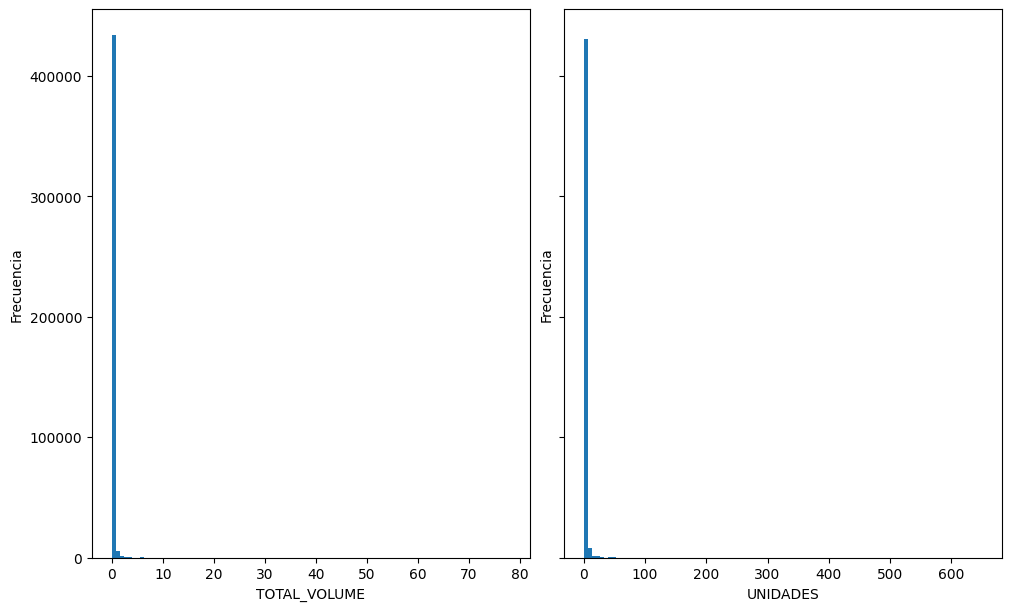

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True, constrained_layout=True)

# Grafico 1
axs[0].hist(ventas['TOTAL_VOLUME'], bins=100)
axs[0].set_xlabel("TOTAL_VOLUME")
axs[0].set_ylabel("Frecuencia")

# Grafico 2
axs[1].hist(ventas['UNIDADES'], bins=100)
axs[1].set_xlabel("UNIDADES")
axs[1].set_ylabel("Frecuencia")

plt.savefig('Outliers_ventas', dpi=300, facecolor='white');


#fig.suptitle('Detección de outliers')

plt.show()



In [21]:
ventas



TOTAL_VOLUME = ventas_dic_23['TOTAL_VOLUME'].value_counts()
print(TOTAL_VOLUME)

UNIDADES = ventas_dic_23['UNIDADES'].value_counts()
print(UNIDADES)




TOTAL_VOLUME
0.12000    4596
0.02838    3490
0.11352    2445
0.05676    2135
0.24000    1438
           ... 
7.32000       1
0.78720       1
0.16575       1
0.68112       1
3.51000       1
Name: count, Length: 295, dtype: int64
UNIDADES
1.000000      14043
2.000000       5347
4.000000       1837
3.000000       1811
0.000000        906
              ...  
180.000000        1
2.166667          1
1.916667          1
8.916667          1
61.000000         1
Name: count, Length: 111, dtype: int64


In [22]:
ventas_dic_23.describe()

,POC_ID,ORDER_DATE,SKU,TOTAL_VOLUME,UNIDADES
count,25771.000000,25771,25771.000000,25771.000000,2.577100e+04
mean,391219.388732,2023-12-12 02:38:58.163051520,19498.069380,0.163990,2.155123e+00
min,22247.000000,2023-12-01 00:00:00,2110.000000,0.000000,-2.775558e-16
25%,382530.000000,2023-12-07 00:00:00,16667.000000,0.040000,1.000000e+00
50%,429538.000000,2023-12-13 00:00:00,19259.000000,0.113520,1.000000e+00
75%,451842.000000,2023-12-18 00:00:00,25689.000000,0.120000,2.000000e+00
max,677317.000000,2023-12-21 00:00:00,30286.000000,25.440000,2.120000e+02
std,105308.212420,NaN,8206.840897,0.556338,5.025231e+00


In [23]:
ventas.loc[ventas.TOTAL_VOLUME>7].describe()

,POC_ID,ORDER_DATE,SKU,TOTAL_VOLUME,UNIDADES
count,293.000000,293,293.000000,293.000000,293.000000
mean,437760.873720,2023-08-01 23:35:25.597269504,16202.488055,12.589197,110.451081
min,142908.000000,2022-12-02 00:00:00,2218.000000,7.020000,59.000000
25%,433940.000000,2023-05-09 00:00:00,7038.000000,9.600000,89.000000
50%,437341.000000,2023-09-11 00:00:00,7634.000000,12.000000,100.000000
75%,453277.000000,2023-11-22 00:00:00,27488.000000,12.840000,108.000000
max,467899.000000,2024-01-06 00:00:00,29790.000000,78.000000,650.000000
std,28703.638526,NaN,9992.232399,5.925068,58.537902


In [24]:
ventas.loc[ventas.UNIDADES>25].describe()

,POC_ID,ORDER_DATE,SKU,TOTAL_VOLUME,UNIDADES
count,1561.000000,1561,1561.000000,1561.000000,1561.000000
mean,425721.621397,2023-07-07 03:48:46.585522176,16257.548366,5.871280,55.528881
min,27085.000000,2022-12-01 00:00:00,2201.000000,0.529760,26.000000
25%,432243.000000,2023-02-27 00:00:00,7038.000000,3.600000,33.000000
50%,440636.000000,2023-08-09 00:00:00,16811.000000,5.400000,50.000000
75%,453277.000000,2023-10-26 00:00:00,26567.000000,6.360000,55.000000
max,469278.000000,2024-01-06 00:00:00,30286.000000,78.000000,650.000000
std,66231.051481,NaN,9276.907695,4.414694,38.995262


La mayoria de los valores de "TOTAL_VOLUME" son valores menores a 5. Para el caso de "UNIDADES", la mayoria de las unidades por compra son menos de 25.

## 3- Detección de Outliers

De los analisis anteriores, se ve que puede haber outliers en la tabla "ventas" en las columnas 'TOTAL_VOLUME', 'UNIDADES', y en la tabla "promociones" en 'MIN_QTY'.


**¿Qué hacer con los outliers?**

En este trabajo me surgió la incomodidad de eliminar los outliers. Al menos me planteé la utilidad de un análisis con ellos o sin ellos.

Como aqui queremos ver que tal funciona el algoritmo de asignacion de promociones, no podemos perder la posibilidad de analizar que pasa con los clientes que tienen grandes volumenes de compras. Sin embargo, es necesario separar los datos para que estos grandes valores no introduzcan ruidos a la generalidad de clientes. Por lo tanto, he decidido hacer dos análisis distintos, uno considerando los outliers y otro sin ellos.



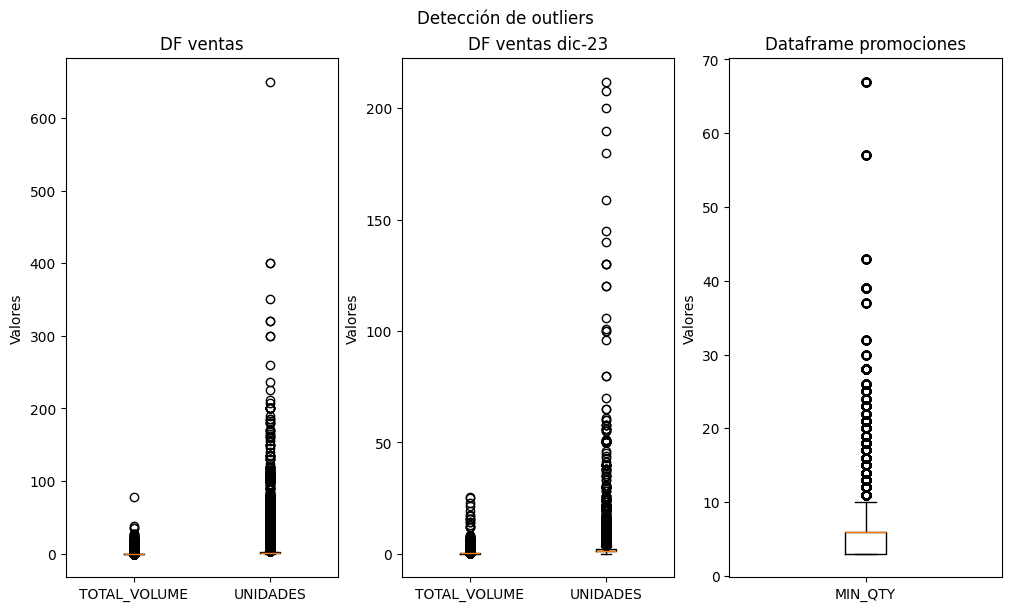

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6), constrained_layout=True)

# Grafico 1
axs[0].boxplot(ventas[['TOTAL_VOLUME', 'UNIDADES']])
axs[0].set_ylabel('Valores')
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['TOTAL_VOLUME', 'UNIDADES'])
axs[0].set_title('DF ventas')

# Grafico 2
axs[1].boxplot(ventas_dic_23[['TOTAL_VOLUME', 'UNIDADES']])
axs[1].set_ylabel('Valores')
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['TOTAL_VOLUME', 'UNIDADES'])
axs[1].set_title('DF ventas dic-23')

# Grafico 3
axs[2].boxplot(promociones[['MIN_QTY']])
axs[2].set_ylabel('Valores')
axs[2].set_xticks([1])
axs[2].set_xticklabels(['MIN_QTY'])
axs[2].set_title('Dataframe promociones')

fig.suptitle('Detección de outliers')
plt.savefig('Outliers_boxplot', dpi=300, facecolor='white');
plt.show()


In [26]:
#funcion para eliminar outliers
def elimino_outliers(df, campo, k):
    iqr = df[campo].quantile(0.75) - df[campo].quantile(0.25) # rango intercuartilico
    #iqr = ventas['TOTAL_VOLUME'].quantile(0.75) - ventas['TOTAL_VOLUME'].quantile(0.25)
   
    df= df.drop(df[(df[campo] < df[campo].quantile(0.25) - k * iqr) | 
                   (df[campo] > df[campo].quantile(0.75) + k * iqr)
                   ].index)
    return df

In [27]:
#Los dataframes con ouliers dropeados tienen el subindice o
ventas_o = elimino_outliers(ventas, 'UNIDADES', 3)
ventas_o = elimino_outliers(ventas, 'TOTAL_VOLUME', 3)
promociones_o = elimino_outliers(promociones,'MIN_QTY', 3)

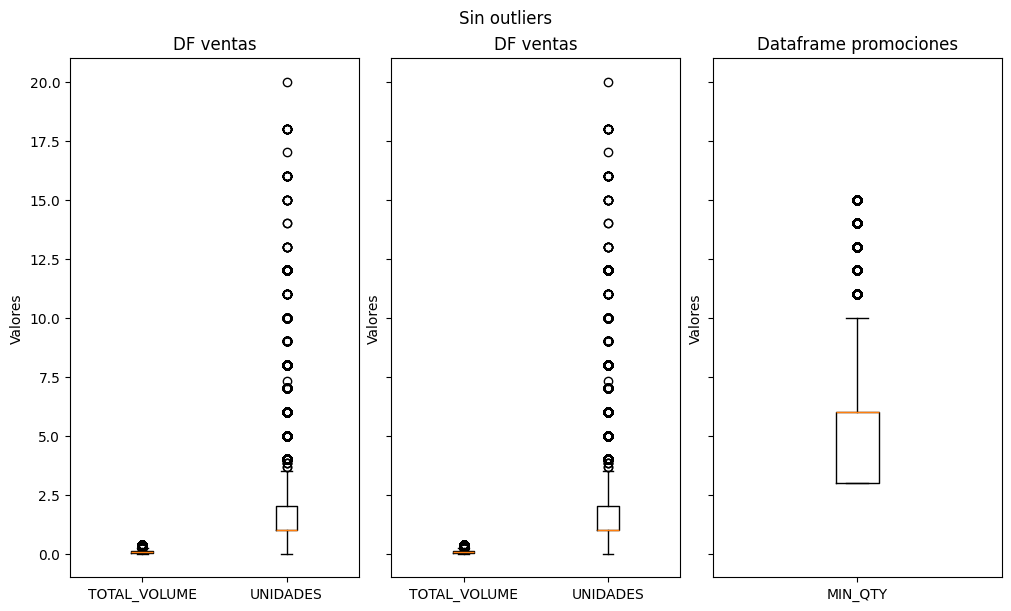

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharey=True, constrained_layout=True)

axs[0].boxplot(ventas_o[['TOTAL_VOLUME', 'UNIDADES']])
axs[0].set_ylabel('Valores')
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['TOTAL_VOLUME', 'UNIDADES'])
axs[0].set_title('DF ventas')

axs[1].boxplot(ventas_o[['TOTAL_VOLUME', 'UNIDADES']])
axs[1].set_ylabel('Valores')
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['TOTAL_VOLUME', 'UNIDADES'])
axs[1].set_title('DF ventas')


axs[2].boxplot(promociones_o[['MIN_QTY']])
axs[2].set_ylabel('Valores')
axs[2].set_xticks([1])
axs[2].set_xticklabels(['MIN_QTY'])
axs[2].set_title('Dataframe promociones')
fig.suptitle('Sin outliers')
plt.savefig('SIN_Outliers_boxplot', dpi=300, facecolor='white');
plt.show()


 Ademas considerar que se tomo k=3. 

## 4- Unión de las tablas promociones y ventas
Como determinar si una venta es debido a una promoción o no?

Interpreto que para saber si la venta es producto de una promoción, se deben cumplir las siguientes condiciones al mismo tiempo:
- El SKU de la tabla venta corresponde con el SKU de la promoción.
- La fecha de la orden (tabla venta), corresponde con el período de la promoción.


Utilizaré para unir las tablas Merge de pandas. El merge se realizará sobre las columnas SKU y POC_ID. 



In [29]:
ventas_dic_23_o = ventas_o.drop(ventas_o[(ventas_o.ORDER_DATE<'2023-12-01') | (ventas_o.ORDER_DATE>'2023-12-21')].index)
#merge de las tablas:
ven_dic_23_y_prom = pd.merge(ventas_dic_23, promociones, on=['SKU', 'POC_ID'], how='inner')
ven_dic_23_y_prom_o = pd.merge(ventas_dic_23_o, promociones_o, on=['SKU', 'POC_ID'], how='inner')


**Redenciones:**

Se considera una redencion cuando el cliente adquiere un producto ofrecido por la promoción en la ventana de tiempo de vigencia de la promoción, incluso aunque no haya adquirido la promoción. Para que el cliente adquiera el descuento, debe comprar la cantidad mínima.

- La cantidad de venta para esa orden (unidades en tabla venta), esta en el rango de MIN_QTY y MAX_QTY de unidades de la tabla promoción.

In [50]:
#Filtrado de las redenciones:
#tabla con Outliers
ven_dic_23_y_prom['REDEMPTION'] = False # creo una columna 'redemption' y le asigno el valor False.
ven_dic_23_y_prom.loc[((ven_dic_23_y_prom['ORDER_DATE'] >= ven_dic_23_y_prom['PERIOD_START_DT']) & (ven_dic_23_y_prom['ORDER_DATE']<=ven_dic_23_y_prom['PERIOD_END_DT'])
                ), 'REDEMPTION'] = True # a los registros que cumplan las condiciones, se les asigna el valor True en la columna 'redemption'.

#Tabla libre de outliers
ven_dic_23_y_prom_o['REDEMPTION'] = False
ven_dic_23_y_prom_o.loc[((ven_dic_23_y_prom_o['ORDER_DATE'] >= ven_dic_23_y_prom_o['PERIOD_START_DT']) & (ven_dic_23_y_prom_o['ORDER_DATE']<=ven_dic_23_y_prom_o['PERIOD_END_DT'])
                ), 'REDEMPTION'] = True


# Para el dataframe con outliers (ven_dic_23_y_prom)
# Selecciona solo las filas donde 'REDEMPTION' es True
ven_dic_23_y_prom = ven_dic_23_y_prom[ven_dic_23_y_prom['REDEMPTION'] == True]

# Para el dataframe sin outliers (ven_dic_23_y_prom_o)
# Selecciona solo las filas donde 'REDEMPTION' es True
ven_dic_23_y_prom_o = ven_dic_23_y_prom_o[ven_dic_23_y_prom_o['REDEMPTION'] == True]


In [31]:
# Creo una columma llamada "ES_PROMOCION" con valores booleanos. Será 'TRUE' si se cumplen las condiciones que se mencionaron para que una una promocion se corresponda con una venta
ven_dic_23_y_prom['ES_PROMOCION'] = False
ven_dic_23_y_prom.loc[((ven_dic_23_y_prom['ORDER_DATE'] >= ven_dic_23_y_prom['PERIOD_START_DT']) & (ven_dic_23_y_prom['ORDER_DATE']<=ven_dic_23_y_prom['PERIOD_END_DT'])&
                (ven_dic_23_y_prom['UNIDADES'] >= ven_dic_23_y_prom['MIN_QTY']) & (ven_dic_23_y_prom['UNIDADES']<=ven_dic_23_y_prom['MAX_QTY'])), 'ES_PROMOCION'] = True

ven_dic_23_y_prom_o['ES_PROMOCION'] = False
ven_dic_23_y_prom_o.loc[((ven_dic_23_y_prom_o['ORDER_DATE'] >= ven_dic_23_y_prom_o['PERIOD_START_DT']) & (ven_dic_23_y_prom_o['ORDER_DATE']<=ven_dic_23_y_prom_o['PERIOD_END_DT'])&
                (ven_dic_23_y_prom_o['UNIDADES'] >= ven_dic_23_y_prom_o['MIN_QTY']) & (ven_dic_23_y_prom_o['UNIDADES']<=ven_dic_23_y_prom_o['MAX_QTY'])), 'ES_PROMOCION'] = True

Voy a calcular las siguientes métricas para el grupo 0, grupo 1 y el total:
- **número de redenciones:** aquellas ventas de productos que hayan sido ofrecidos por promociones, y que se hayan adquirido en la fecha de la promoción, pero que no tengan que cumplir necesariamente la condicion de MIN_QTY.
- **número de promociones aceptadas:** Aquellas ventas que cumplan con las condiciones de las promociones y entonces accedieron al beneficio del descuento, para grupo 1, 0 y en general.
- **número de compras totales:** cantidad total de ventas en el período.
- **número de clientes redimidos (grupo 0 y 1).**
- **número de clientes que adquirieron promoción (grupo 1 y 0).**
- **número de clientes de clientes que hayan realizado compras.**

Para de este modo determinar:
- redemption rate simple

$$
\text{Redemption Rate Simple} = \frac{\text{Número de clientes redimidos}}{\text{Número de clientes promoción grupo}}
$$


- redemption rate REAL
$$
\text{Redemption Rate Real} = \frac{\text{Número de clientes que adquirieron promoción}}{\text{Número de clientes promocion grupo}}
$$


Respecto al denominador de ambos rates, se toma el número de clientes filtrando de la tabla promociones el grupo 1 o 0 según corresponda.

In [32]:
# Con esta funcion se calculan las redenciones
def redemption(df):

    #num de clientes
    num_clientes_redenciones_g1 = df.loc[(df['REDEMPTION']==True)&(df['MEASUREMENT_GROUP']==1)].POC_ID.nunique()
    num_clientes_redenciones_g0 = df.loc[(df['REDEMPTION']==True)&(df['MEASUREMENT_GROUP']==0)].POC_ID.nunique()
    num_clientes_redenciones_aceptadas = df.loc[(df['REDEMPTION']==True)].POC_ID.nunique()
    num_clientes_promociones_aceptadas_g1= df.loc[(df['ES_PROMOCION']==True) & (df['MEASUREMENT_GROUP']==1)].POC_ID.nunique()
    num_clientes_promociones_aceptadas_g0 = df.loc[(df['ES_PROMOCION']==True) & (df['MEASUREMENT_GROUP']==0)].POC_ID.nunique()
    num_clientes_promociones_aceptadas = df.loc[df['ES_PROMOCION']==True].POC_ID.nunique()
    num_clientes_compras_totales = df.POC_ID.nunique()

    # num clientes por grupo

    num_clientes_promocion_g1 = promociones.loc[promociones.MEASUREMENT_GROUP==1].POC_ID.nunique()
    num_clientes_promocion_g0 = promociones.loc[promociones.MEASUREMENT_GROUP==0].POC_ID.nunique()
    num_clientes_promocion = promociones.POC_ID.nunique()

    #calculo redemption rate

    redemption_rate_g1 = num_clientes_redenciones_g1/num_clientes_promocion_g1
    redemption_rate_g0 = num_clientes_redenciones_g0/num_clientes_promocion_g0
    redemption_rate_tot = num_clientes_redenciones_aceptadas/num_clientes_promocion
    redemption_rate_REAL_g1 = num_clientes_promociones_aceptadas_g1/num_clientes_promocion_g1
    redemption_rate_REAL_g0 = num_clientes_promociones_aceptadas_g0/num_clientes_promocion_g0
    redemption_rate_REAL = num_clientes_promociones_aceptadas/num_clientes_promocion


    print(f'redemption_rate_simple_g1: {redemption_rate_g1:.2f}')
    print(f'redemption_rate_simple_g0: {redemption_rate_g0:.2f}')
    print(f'redemption_rate_simple_tot (ambos grupos): {redemption_rate_tot:.2f}')

    print(f'redemption_rate_REAL_g1: {redemption_rate_REAL_g1:.2f}')
    print(f'redemption_rate_REAL_g0: {redemption_rate_REAL_g0:.2f}')
    print(f'redemption_rate_REAL (ambos grupos): {redemption_rate_REAL:.2f}')
    return num_clientes_promocion_g0


In [33]:
#Con Outliers
print(redemption(ven_dic_23_y_prom))

redemption_rate_simple_g1: 0.56
redemption_rate_simple_g0: 0.55
redemption_rate_simple_tot (ambos grupos): 0.55
redemption_rate_REAL_g1: 0.10
redemption_rate_REAL_g0: 0.12
redemption_rate_REAL (ambos grupos): 0.11
1130


In [34]:
#Sin Outliers
redemption(ven_dic_23_y_prom_o)

redemption_rate_simple_g1: 0.54
redemption_rate_simple_g0: 0.53
redemption_rate_simple_tot (ambos grupos): 0.54
redemption_rate_REAL_g1: 0.03
redemption_rate_REAL_g0: 0.07
redemption_rate_REAL (ambos grupos): 0.05


1130

## 5- Redemption Rate simple

El cliente solicita:

_Calcular la redemption rate SIMPLE: proporción de clientes que al menos compraron 1 producto de la promo (sin importar la cantidad)._

De acuerdo a esta solicitud, interpreto que los clientes redimidos son aquellos que adquieren un producto de la promo incluso sin haber accedido al descuento de la promocion. Es decir, adquirieron los productos de la promocion y en la fecha de vigencia, pero no necesariamente alcanzaron la cantidad minima MIN_QTY.

Para realizar los calculos, dada la característica de los outliers, calculo con outliers y sin outliers.




## 6- Redemption Rate Real

El cliente solicita:

_Calcular la redemption rate REAL: % clientes que compraron una cantidad de unidades mayor o igual a la asignada por el algoritmo.._

De acuerdo a lo indicado, para que los clientes hayan accedido a la promocion, deben haber realizado una compra de un producuto ofrecido en promoción, en el rango de validez de fechas y por una cantidad mayor a la mínima para ingresar a la promocion (MIN_QTY) y menor a la máxima (MAX_QTY).






## 7- Comparar el volumen total y el volumen promedio 

(Aplicaría hoy la mediana teniendo en cuenta el dataset que contiene valores outliers). 

En el enunciado solicitan previamente eliminar outliers. Desde mi punto de vista aporta valor comparar calculos considerando y sin considerar Outliers.

### Cálculo del volumen medio:

Observando el volumen medio por compra, el grupo 0 tiene mejor desempeño tambien en este aspecto. 

El volumen medio de los redimidos REAL es del doble respecto a los redimidos. Esto de alguna forma era de esperarse y es bueno, ya que las promociones cumplen su objetivo de lograr mayores volúmenes de venta. El volumen medio del grupo 0 es mayor que el del 1. 

Sin sacar los outliers, el grupo 1 tiene mucho mejor desempeño. El volumen medio para redimidos real es superior en un 33 % aproximadamente. 



In [35]:
#Cálculo volumen medio sin outliers
# sin outliers
volumen_medio_group_1_o_r = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].mean()
volumen_medio_group_0_o_r = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].mean()
volumen_medio_group_1_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['ES_PROMOCION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].mean()
volumen_medio_group_0_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['ES_PROMOCION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].mean()
volumen_medio_sin_promo_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==False)]['TOTAL_VOLUME'].mean()
print('Sin outliers')
print(f'Volumen medio clientes redimidos grupo 1: {volumen_medio_group_1_o_r:.2f}')
print(f'Volumen medio clientes redimidos grupo 0: {volumen_medio_group_0_o_r:.2f}')
print(f'Volumen medio grupo 1 redimidos real: {volumen_medio_group_1_o:.2f}')
print(f'Volumen medio grupo 0 redimidos real: {volumen_medio_group_0_o:.2f}')
print(f'Volumen medio no redimidos: {volumen_medio_sin_promo_o:.2f}')
try:
    print(f'grupo 0 respecto a grupo 1: {((volumen_medio_group_0_o-volumen_medio_group_1_o)/volumen_medio_group_1_o):.2f}')
except:
    print('grupo 0 respecto a grupo 1: Error al calcular')
#Cálculo volumen medio con outliers
volumen_medio_group_1_r = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].mean()
volumen_medio_group_0_r = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].mean()
volumen_medio_group_1 = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['ES_PROMOCION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].mean()
volumen_medio_group_0 = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['ES_PROMOCION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].mean()
volumen_medio_sin_promo = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==False)]['TOTAL_VOLUME'].mean()
print('Con Outliers')
print(f'Volumen medio clientes redimidos grupo 1: {volumen_medio_group_1_r:.2f}')
print(f'Volumen medio clientes redimidos grupo 0: {volumen_medio_group_0_r:.2f}')
print(f'Volumen medio grupo 1 redimidos real: {volumen_medio_group_1:.2f}')
print(f'Volumen medio grupo 0 redimidos real: {volumen_medio_group_0:.2f}')
print(f'Volumen medio no redimidos: {volumen_medio_sin_promo:.2f}')
#print('grupo 0 respecto a grupo 1', (volumen_medio_group_0_o-volumen_medio_group_1_o)/volumen_medio_group_1_o)


Sin outliers
Volumen medio clientes redimidos grupo 1: 0.12
Volumen medio clientes redimidos grupo 0: 0.12
Volumen medio grupo 1 redimidos real: 0.26
Volumen medio grupo 0 redimidos real: 0.27
Volumen medio no redimidos: nan
grupo 0 respecto a grupo 1: 0.04
Con Outliers
Volumen medio clientes redimidos grupo 1: 0.16
Volumen medio clientes redimidos grupo 0: 0.16
Volumen medio grupo 1 redimidos real: 0.74
Volumen medio grupo 0 redimidos real: 0.56
Volumen medio no redimidos: nan


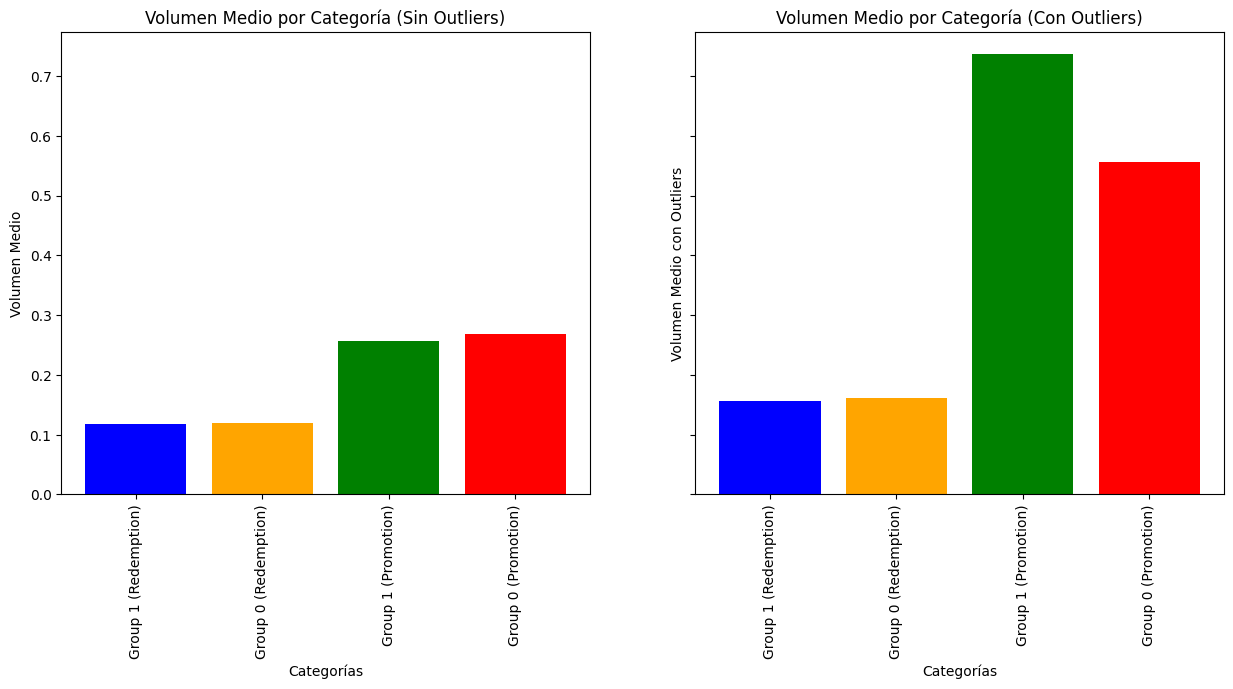

In [36]:
# Categorías y valores sin outliers
categorias_sin_outliers = ['Group 1 (Redemption)', 'Group 0 (Redemption)', 'Group 1 (Promotion)', 'Group 0 (Promotion)', 'Without Promotion']
valores_sin_outliers = [volumen_medio_group_1_o_r, volumen_medio_group_0_o_r, volumen_medio_group_1_o, volumen_medio_group_0_o, volumen_medio_sin_promo_o]

# Categorías y valores con outliers
categorias_con_outliers = ['Group 1 (Redemption)', 'Group 0 (Redemption)', 'Group 1 (Promotion)', 'Group 0 (Promotion)', 'Without Promotion']
valores_con_outliers = [volumen_medio_group_1_r, volumen_medio_group_0_r, volumen_medio_group_1, volumen_medio_group_0, volumen_medio_sin_promo]

# Crear subgráficos
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Gráfico sin outliers
axs[0].bar(categorias_sin_outliers, valores_sin_outliers, color=['blue', 'orange', 'green', 'red', 'purple'])
axs[0].set_xlabel('Categorías')
axs[0].set_ylabel('Volumen Medio')
axs[0].set_title('Volumen Medio por Categoría (Sin Outliers)')
axs[0].tick_params(axis='x', rotation=90)

# Gráfico con outliers
axs[1].bar(categorias_con_outliers, valores_con_outliers, color=['blue', 'orange', 'green', 'red', 'purple'])
axs[1].set_xlabel('Categorías')
axs[1].set_ylabel('Volumen Medio con Outliers')
axs[1].set_title('Volumen Medio por Categoría (Con Outliers)')
axs[1].tick_params(axis='x', rotation=90)
plt.savefig('Volumen_medio', dpi=300, facecolor='white');
plt.show()

In [37]:
def desc_promedio(df, grupo):
    '''# ven_dic_23_y_prom --- IGNORE ---
    '''
    return df.loc[(df['MEASUREMENT_GROUP']==grupo) & (df['REDEMPTION']==True)]['DISCOUNT'].mean()

print('descuento promedio grupo 1:', desc_promedio(ven_dic_23_y_prom, 1))
print('descuento promedio grupo 0:', desc_promedio(ven_dic_23_y_prom, 0))
print('descuento promedio grupo 1 sin outliers:', desc_promedio(ven_dic_23_y_prom_o, 1))
print('descuento promedio grupo 0 sin outliers:', desc_promedio(ven_dic_23_y_prom_o, 0))


descuento promedio grupo 1: 3.1664127306585406
descuento promedio grupo 0: 3.0
descuento promedio grupo 1 sin outliers: 3.133122323589648
descuento promedio grupo 0 sin outliers: 3.0


In [38]:
vol_desc_g1 = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum()/desc_promedio(ven_dic_23_y_prom, 1)
print('ratio volumen descuento grupo 1:', vol_desc_g1)
vol_desc_g0 = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum()/desc_promedio(ven_dic_23_y_prom, 0)
print('ratio volumen descuento grupo 0:', vol_desc_g0)
vol_desc_g1_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum()/desc_promedio(ven_dic_23_y_prom_o, 1)
print('ratio volumen descuento grupo 1 sin outliers:', vol_desc_g1_o)
vol_desc_g0_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum()/desc_promedio(ven_dic_23_y_prom_o, 0)
print('ratio volumen descuento grupo 0 sin outliers:', vol_desc_g0_o)


ratio volumen descuento grupo 1: 292.10920327737375
ratio volumen descuento grupo 0: 326.11186
ratio volumen descuento grupo 1 sin outliers: 201.07002374494886
ratio volumen descuento grupo 0 sin outliers: 227.03697999999994



### Cálculo del volumen total 

El volumen total en el grupo 0 considerando los clientes redimidos es mayor en aproximandamente un 10 %. Pero considerando los clientes redimidos total, triplica al volumen del grupo 1.

Sin sacar los outliers, aqui también puede verse que el grupo 1 tiene mejor desempeño aunque no tan notorio como el en caso de volumen medio por compra. 

**La mayoria del volumen total no es producto de ventas por promociones adquiridas.**

In [39]:
#Calculo volumen total sin outliers:
volumen_total_group_1_o_r = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum()
volumen_total_group_0_o_r = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum()
volumen_total_group_1_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['ES_PROMOCION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum()
volumen_total_group_0_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['ES_PROMOCION']==True) & (ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum()
volumen_total_sin_promo_o = ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['REDEMPTION']==False)]['TOTAL_VOLUME'].sum()



print('calculo volumen total sin outliers')
print('Volumen total clientes redimidos grupo 1:', volumen_total_group_1_o_r)
print('Volumen total clientes redimidos grupo 0:', volumen_total_group_0_o_r)
print('Volumen total grupo 1 redimidos real:', volumen_total_group_1_o)
print('Volumen total grupo 0 redimidos real:', volumen_total_group_0_o)
print('Volumen total no redimidos:', volumen_total_sin_promo_o)

#Calculo volumen total con outliers
volumen_total_group_1_r = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum()
volumen_total_group_0_r = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum()
volumen_total_group_1 = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['ES_PROMOCION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum()
volumen_total_group_0 = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['ES_PROMOCION']==True) & (ven_dic_23_y_prom['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum()
volumen_total_sin_promo = ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['REDEMPTION']==False)]['TOTAL_VOLUME'].sum()
print('Considerando Outliers')
print('Volumen total clientes redimidos grupo 1:', volumen_total_group_1_r)
print('Volumen total clientes redimidos grupo 0:', volumen_total_group_0_r)
print('Volumen total grupo 1 redimidos real:', volumen_total_group_1)
print('Volumen total grupo 0 redimidos real:', volumen_total_group_0)
print('Volumen total no redimidos:', volumen_total_sin_promo)


calculo volumen total sin outliers
Volumen total clientes redimidos grupo 1: 629.9769799999999
Volumen total clientes redimidos grupo 0: 681.1109399999998
Volumen total grupo 1 redimidos real: 12.85596
Volumen total grupo 0 redimidos real: 36.23891999999999
Volumen total no redimidos: 0.0
Considerando Outliers
Volumen total clientes redimidos grupo 1: 924.9382999999998
Volumen total clientes redimidos grupo 0: 978.3355799999999
Volumen total grupo 1 redimidos real: 139.07952
Volumen total grupo 0 redimidos real: 184.85123999999996
Volumen total no redimidos: 0.0


In [40]:
print('Volumen total grupo 1 sin outliers:', ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum())
print('Volumen total grupo 0 sin outliers:', ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum())
print('Volumen total grupo 1 con outliers:', ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['MEASUREMENT_GROUP']==1)]['TOTAL_VOLUME'].sum())
print('Volumen total grupo 0 con outliers:', ven_dic_23_y_prom.loc[(ven_dic_23_y_prom['MEASUREMENT_GROUP']==0)]['TOTAL_VOLUME'].sum())


Volumen total grupo 1 sin outliers: 629.9769799999999
Volumen total grupo 0 sin outliers: 681.1109399999998
Volumen total grupo 1 con outliers: 924.9382999999998
Volumen total grupo 0 con outliers: 978.3355799999999


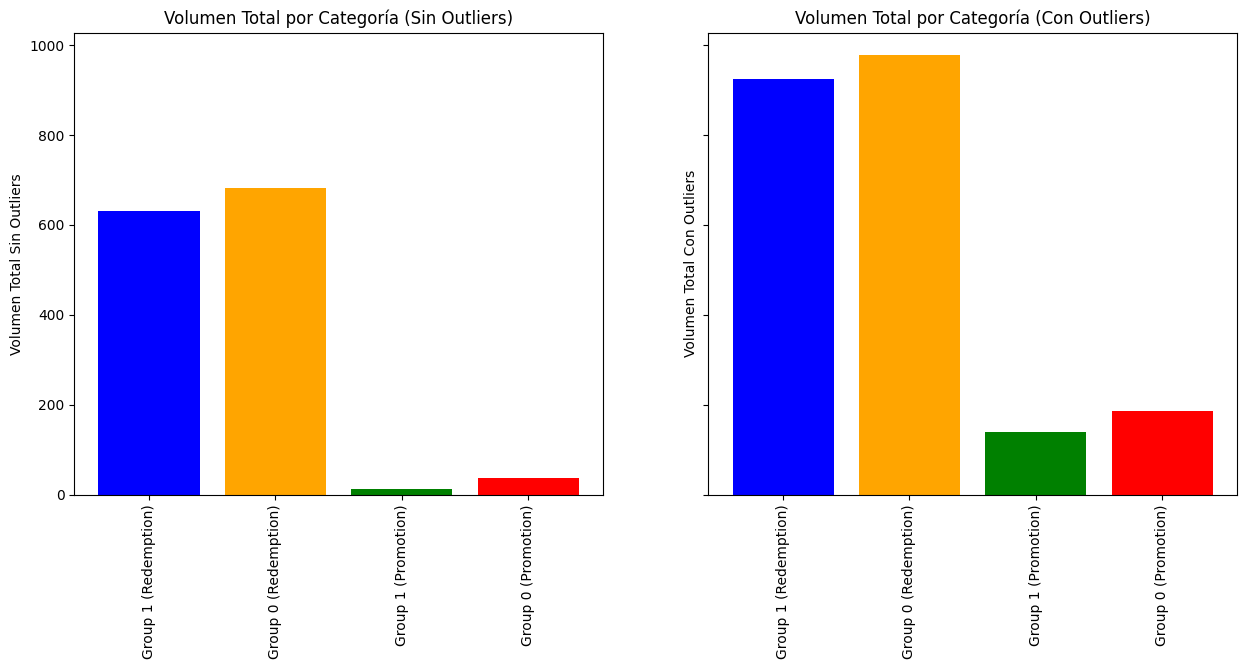

In [41]:


# Categorías y valores sin outliers
categorias_sin_outliers = ['Group 1 (Redemption)', 'Group 0 (Redemption)', 'Group 1 (Promotion)', 'Group 0 (Promotion)']
valores_total_sin_outliers = [volumen_total_group_1_o_r, volumen_total_group_0_o_r, volumen_total_group_1_o, volumen_total_group_0_o]

# Categorías y valores con outliers
categorias_con_outliers = ['Group 1 (Redemption)', 'Group 0 (Redemption)', 'Group 1 (Promotion)', 'Group 0 (Promotion)']
valores_total_con_outliers = [volumen_total_group_1_r, volumen_total_group_0_r, volumen_total_group_1, volumen_total_group_0]


fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Gráfico sin outliers
axs[0].bar(categorias_sin_outliers, valores_total_sin_outliers, color=['blue', 'orange', 'green', 'red', 'purple'])
#axs[0].set_xlabel('Categorías')
axs[0].set_ylabel('Volumen Total Sin Outliers')
axs[0].set_title('Volumen Total por Categoría (Sin Outliers)')
axs[0].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x para mejor legibilidad

# Gráfico con outliers
axs[1].bar(categorias_con_outliers, valores_total_con_outliers, color=['blue', 'orange', 'green', 'red', 'purple'])
#axs[1].set_xlabel('Categorías')
axs[1].set_ylabel('Volumen Total Con Outliers')
axs[1].set_title('Volumen Total por Categoría (Con Outliers)')
axs[1].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x para mejor legibilidad
plt.savefig('Volumen_total', dpi=300, facecolor='white');
plt.show()


Para concluir el análisis exploratorio de los datos, podemos ver que en general el algoritmo 0 obtiene mejores resultados. En prácticamente todas las métricas el grupo 0 tiene mejor desempeño. La excepción es el volumen medio de producto adquirido por el cliente en el caso de que hayan adquirido la promoción.

Para eliminar todo tipo de dudas, podemos observar la ultima métrica que es el volumen total de producto vendido a los clientes segun grupo. Puede verse que en esa métrica también el grupo 0 tiene mejor desempeño.

#### **Con outliers vs sin outliers**

Sin eliminar Outliers, el rendimiento del grupo 1 mejora (porque el grupo 1 logra ventas muy grandes que justamente son outliers), pero no logra ganarle a los del grupo 0.

## 8- Análisis del desempeño del algoritmo

Si se analiza el comportamiento histórico de compra de los clientes de cada grupo ¿En qué medida son alcanzables las cantidades mínimas exigidas por el algoritmo?

Para analizar el comportamiento histórico de los clientes, como los datos de promociones que se tienen son de diciembre del 2023, se analizará el comportamiento de los clientes en diciembre del 2022 por una cuestion de estacionalidad.

In [42]:
ventas_dic_22 = ventas.loc[(ventas.ORDER_DATE >='2022-12-01') & (ventas.ORDER_DATE<='2022-12-21')]
ventas_dic_22_o = ventas.loc[(ventas_o.ORDER_DATE >='2022-12-01') & (ventas.ORDER_DATE<='2022-12-21')]


In [43]:
# group_1 y group_0 son arrays que tienen a los clientes del grupo 1 y 0 respectivamente.
group_1 = promociones.loc[promociones.MEASUREMENT_GROUP==1]['POC_ID'].unique()
group_0 = promociones.loc[promociones.MEASUREMENT_GROUP==0]['POC_ID'].unique()


In [44]:
ventas_dic_22_g1 = ventas_dic_22[ventas_dic_22['POC_ID'].isin(group_1)]
ventas_dic_22_g0 = ventas_dic_22[ventas_dic_22['POC_ID'].isin(group_0)]
ventas_dic_22_g1_o = ventas_dic_22_o[ventas_dic_22_o['POC_ID'].isin(group_1)]
ventas_dic_22_g0_o = ventas_dic_22_o[ventas_dic_22_o['POC_ID'].isin(group_0)]

In [45]:
promociones_1 = promociones.loc[promociones.MEASUREMENT_GROUP==1]
promociones_0 = promociones.loc[promociones.MEASUREMENT_GROUP==0]
promociones_1_o = promociones_o.loc[promociones_o.MEASUREMENT_GROUP==1]
promociones_0_o = promociones_o.loc[promociones_o.MEASUREMENT_GROUP==0]


In [46]:
print(f'media unidades vendidas dic 22 grupo 1: {ventas_dic_22_g1.UNIDADES.mean():.2f}')
print(f'media unidades vendidas dic 22 grupo 1 (sin outliers): {ventas_dic_22_g1_o.UNIDADES.mean():.2f}')
print(f'media unidades vendidas dic 22 grupo 0: {ventas_dic_22_g0.UNIDADES.mean():.2f}')
print(f'media unidades vendidas dic 22 grupo 0 (sin outliers): {ventas_dic_22_g0_o.UNIDADES.mean():.2f}')
print(f"media de MIN_QTY grupo 1 en promociones adquiridas (sin Outliers): {ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o.MEASUREMENT_GROUP==1) & (ven_dic_23_y_prom_o['ES_PROMOCION']==True)].MIN_QTY.mean():.2f}")
print(f"media de MIN_QTY grupo 1 en promociones adquiridas: {ven_dic_23_y_prom.loc[(ven_dic_23_y_prom.MEASUREMENT_GROUP==1) & (ven_dic_23_y_prom['ES_PROMOCION']==True)].MIN_QTY.mean():.2f}")
print(f"media de MIN_QTY grupo 1: {ven_dic_23_y_prom.loc[ven_dic_23_y_prom.MEASUREMENT_GROUP==1].MIN_QTY.mean():.2f}")
print(f"media de MIN_QTY grupo 1 (sin Outliers): {ven_dic_23_y_prom_o.loc[ven_dic_23_y_prom_o.MEASUREMENT_GROUP==1].MIN_QTY.mean():.2f}")
print(f"media de MIN_QTY grupo 0 en promociones adquiridas: {ven_dic_23_y_prom.loc[(ven_dic_23_y_prom.MEASUREMENT_GROUP==0) & (ven_dic_23_y_prom['ES_PROMOCION']==True)].UNIDADES.mean():.2f}")
print(f"media de MIN_QTY grupo 0 en promociones adquiridas (sin Outliers): {ven_dic_23_y_prom_o.loc[(ven_dic_23_y_prom_o.MEASUREMENT_GROUP==0) & (ven_dic_23_y_prom_o['ES_PROMOCION']==True)].UNIDADES.mean():.2f}")
print(f"media de MIN_QTY grupo 0: {ven_dic_23_y_prom.loc[ven_dic_23_y_prom.MEASUREMENT_GROUP==0].MIN_QTY.mean():.2f}")
print(f"media de MIN_QTY grupo 0 (sin outliers): {ven_dic_23_y_prom_o.loc[ven_dic_23_y_prom_o.MEASUREMENT_GROUP==0].MIN_QTY.mean():.2f}")



media unidades vendidas dic 22 grupo 1: 2.34
media unidades vendidas dic 22 grupo 1 (sin outliers): 1.70
media unidades vendidas dic 22 grupo 0: 2.31
media unidades vendidas dic 22 grupo 0 (sin outliers): 1.73
media de MIN_QTY grupo 1 en promociones adquiridas (sin Outliers): 3.74
media de MIN_QTY grupo 1 en promociones adquiridas: 5.31
media de MIN_QTY grupo 1: 5.88
media de MIN_QTY grupo 1 (sin Outliers): 5.24
media de MIN_QTY grupo 0 en promociones adquiridas: 5.45
media de MIN_QTY grupo 0 en promociones adquiridas (sin Outliers): 3.41
media de MIN_QTY grupo 0: 4.50
media de MIN_QTY grupo 0 (sin outliers): 4.50


De nuevo aqui hay que separar el analisis en dos partes, sin Outliers, y con Outliers. 

Analisis sin outliers: 

La media de unidades compradas por los clientes de cada grupo en diciembre del 2022 es de:

- grupo 1 : 1.65
- grupo 0 : 1.67

Muy similares.

Mientras que la media de MIN_QTY es:

- grupo 1 : 5.33
- grupo 0 : 4.5

Ahora si observamos la media de MIN_QTY de promociones adquiridas, 3.74 y 3.42 respectivamente, se ve que esta medida está bastante por debajo de lo ofrecido. Es decir, la mayoria de las ventas se hicieron con compras con MIN_QTY bajos y por debajo de la media ofrecida.

Con Outliers el resultado es distinto y mas alentador:

La media de unidades compradas por los clientes de cada grupo en diciembre del 2022 es de:

- grupo 1 : 2.26
- grupo 0 : 2.29

Muy similares entre ellos tambien tambiém.

Mientras que la media de MIN_QTY ofrecida es:

- grupo 1 : 6.00
- grupo 0 : 4.50 (la misma que sin outliers, recordar de mas arriba que los outliers en MIN_QTY son solo de grupo 1)

La media de MIN_QTY en las promociones adquiridas es de 5.30 y 5.45 para clientes del grupo 1 y 0 respectivamente. Estos valores estan mas cercanos a las medias de MIN_QTY ofrecidos y hacen pensar que los valores de MIN_QTY bajo este analisis es correcto.

- La tasa de redencion real en clientes con mayor volumen de compra es mayor en el grupo 1 respecto al grupo 0. En el sector medio, es igual. En clientes con mas bajo nivel de compra es menor.

- El mayor volumen de compra es medio y total, se alcanza con clientes del sector de grandes compradores.


## ¿Pero el algoritmo funciona o no?


Todas las métricas hasta ahora parecen indicar que el algoritmo no funciona, pero en realidad no fue creado para vender mas, sino para perder menos dinero en promociones. Es decir, para ver si el algoritmo permite ahorrar dinero o no, lo que podemos hacer (ya que no tenemos datos de precios ni de monto de dinero) calcular la métrica volumen total de ventas bajo promociones * descuento promedio:

In [56]:
# Función para calcular (Volumen Total en Promo) * (Descuento Promedio)
def calcular_metrica_promo(df, nombre_escenario):
    print(f"--- Métrica Promocional: Volumen Total Promo * Descuento Promedio ({nombre_escenario}) Cuanto mas bajo, mejor---")
    
    for grupo in [0, 1]:
        # 1. Filtramos solo las ventas que fueron PROMOCIÓN y del grupo correspondiente
        df_promo_grupo = df[(df['MEASUREMENT_GROUP'] == grupo) & (df['ES_PROMOCION'] == True)]
        
        # 2. Volumen Total vendido en promoción
        volumen_total_promo = df_promo_grupo['TOTAL_VOLUME'].sum()
        
        # 3. Descuento Promedio en esas ventas promocionales
        descuento_promedio = df_promo_grupo['DISCOUNT'].mean()
        
        # 4. Métrica
        metrica = volumen_total_promo * descuento_promedio
        
        print(f"Grupo {grupo}:")
        print(f"  Volumen Promo: {volumen_total_promo:.2f}")
        print(f"  Desc. Promedio: {descuento_promedio:.2f}")
        print(f"  Métrica Final: {metrica:.2f}")
        print("-" * 30)
# Calcular para CON outliers
calcular_metrica_promo(ven_dic_23_y_prom, "Con Outliers")
# Calcular para SIN outliers
calcular_metrica_promo(ven_dic_23_y_prom_o, "Sin Outliers")

--- Métrica Promocional: Volumen Total Promo * Descuento Promedio (Con Outliers) Cuanto mas bajo, mejor---
Grupo 0:
  Volumen Promo: 184.85
  Desc. Promedio: 2.49
  Métrica Final: 461.01
------------------------------
Grupo 1:
  Volumen Promo: 139.08
  Desc. Promedio: 2.90
  Métrica Final: 403.26
------------------------------
--- Métrica Promocional: Volumen Total Promo * Descuento Promedio (Sin Outliers) Cuanto mas bajo, mejor---
Grupo 0:
  Volumen Promo: 36.24
  Desc. Promedio: 2.13
  Métrica Final: 77.31
------------------------------
Grupo 1:
  Volumen Promo: 12.86
  Desc. Promedio: 2.32
  Métrica Final: 29.83
------------------------------


Estas últimas metricas muestran un dato bastante escondido, pero son reveladoras.

- Considerando los outliers, el algoritmo logra una métrica (que aproxima, desde luego, un ahorro) del 15 %.

- Para el caso sin outliers, el algoritmo logra una métrica de mas del 50 % de ahorro.